# **Bangkit Final Project: World Coin Classification**

# **Dependencies**

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import zipfile

from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import Xception
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, image, img_to_array
from keras.regularizers import Regularizer, l2

from google.colab import files

In [0]:
# Upload the kaggle.json file from Kaggle account settings page
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
# Install the Kaggle API client
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

# **Importing Dataset**

In [0]:
# Download the dataset
!kaggle datasets download -d wanderdust/coin-images

 98% 452M/459M [00:07<00:00, 68.4MB/s]
100% 459M/459M [00:07<00:00, 63.0MB/s]


In [0]:
# Unzip the dataset into folder
zip_ref = zipfile.ZipFile('/content/coin-images.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

# **Data Preparation**

In [0]:
# Define directories
data_dir = "/content/coins/data/"

train_dir = data_dir + "train/"
validation_dir = data_dir + "validation/"
test_dir = data_dir + "test/"

In [0]:
# Create generators
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(
      rescale=1./255,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False
)

In [0]:
# Read images from generators
batch_size = 32
image_width = 224
image_height = 224

train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(image_width, image_height),
      class_mode="categorical",
      batch_size=batch_size
)

validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(image_width, image_height),
      class_mode="categorical",
      batch_size=batch_size
)

test_generator = test_datagen.flow_from_directory(
      test_dir,
      target_size=(image_width, image_height),
      class_mode="categorical",
      batch_size=1
)

Found 6413 images belonging to 211 classes.
Found 844 images belonging to 211 classes.
Found 844 images belonging to 211 classes.


# **Model**

In [0]:
# Load base model
base_model = Xception(input_shape=(image_width, image_height, 3), weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = True

    # Add regularizer
    l2_layer = l2(1e-4)
    if hasattr(layer, 'kernel'):
        base_model.add_loss(lambda layer=layer: l2_layer(layer.kernel))

# Custom top classifier for model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(211, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_14[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
# Callback to reduce learning rate if no improvement in validation loss for certain number of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)

# Callback to stop training if no improvement in validation loss for certain number of epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Callback to save best model weights per epoch
weights_filepath = "best_model_weights.hdf5"
checkpoint = ModelCheckpoint(
    filepath=weights_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=100,
    steps_per_epoch=50,
    validation_data=validation_generator,
    verbose=1,
    validation_steps=3,
    callbacks=[reduce_lr, early_stop, checkpoint]
)

Epoch 1/100
50/50 [==============================] - 113s 2s/step - loss: 5.3180 - accuracy: 0.0127 - val_loss: 5.3648 - val_accuracy: 0.0104

Epoch 00001: val_accuracy improved from -inf to 0.01042, saving model to best_model_weights.hdf5
Epoch 2/100
50/50 [==============================] - 94s 2s/step - loss: 5.1053 - accuracy: 0.0744 - val_loss: 4.9749 - val_accuracy: 0.0521

Epoch 00002: val_accuracy improved from 0.01042 to 0.05208, saving model to best_model_weights.hdf5
Epoch 3/100
50/50 [==============================] - 94s 2s/step - loss: 4.7344 - accuracy: 0.1331 - val_loss: 4.3621 - val_accuracy: 0.1875

Epoch 00003: val_accuracy improved from 0.05208 to 0.18750, saving model to best_model_weights.hdf5
Epoch 4/100
50/50 [==============================] - 94s 2s/step - loss: 4.2416 - accuracy: 0.2131 - val_loss: 3.9109 - val_accuracy: 0.2500

Epoch 00004: val_accuracy improved from 0.18750 to 0.25000, saving model to best_model_weights.hdf5
Epoch 5/100
50/50 [===============

In [0]:
# Load best model weights
model.load_weights(weights_filepath)

# Save model
model.save("model.h5")

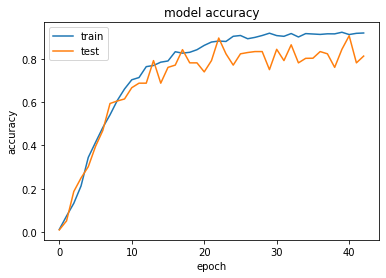

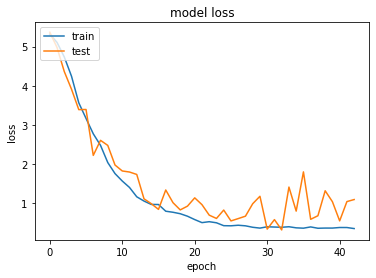

In [0]:
# Visualise accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Visualise loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Evaluate model
train_score = model.evaluate_generator(train_generator, verbose=1)
print("Training loss: ", train_score[0])
print("Training accuracy: ", train_score[1])

test_score = model.evaluate_generator(test_generator, verbose=1)
print("Testing loss: ", test_score[0])
print("Testing accuracy: ", test_score[1])

201/201 [==============================] - 131s 650ms/step
Training loss:  0.3652561902999878
Training accuracy:  0.9474505186080933
844/844 [==============================] - 27s 33ms/step
Testing loss:  0.6549749970436096
Testing accuracy:  0.850710928440094


In [0]:
# Predict test images
predictions = []

for filename in test_generator.filenames:
    img = image.load_img(test_dir+filename, target_size=(224,224))
    img = image.img_to_array(img)/255
    img_expand = np.expand_dims(img, axis=0)
    predictions.append(model.predict(img_expand)[0])

In [0]:
# Get index of largest probability
predicted_indices = np.argmax(predictions, axis=1)

# Get coin directory name from index 
directories = dict((v, k) for k, v in train_generator.class_indices.items())
predicted_dir = [directories.get(k) for k in predicted_indices]

# Get label name from coin directory name
with open(data_dir + 'cat_to_name.json', 'r') as json_file:
    labels = json.load(json_file)
predicted_labels = [labels.get(str(k)) for k in predicted_dir]

In [0]:
# Save predicted labels as CSV file
filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames, "Predictions": predicted_labels})
results.to_csv("results.csv", index=False)
results.head()

,Filename,Predictions
0,1/021__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
1,1/022__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
2,1/027__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
3,1/036__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
4,10/005__5 Centavos_brazil.jpg,"5 Centavos,Brazilian Real,brazil"
